In [1]:
# %%
# ===============================================================
# COMPREHENSIVE ANALYSIS: QUANTUM STEERING ACROSS HAMILTONIANS & STATES
# ===============================================================

import numpy as np
import qutip as qt
import cvxpy as cp
from scipy.linalg import logm, expm
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import seaborn as sns
from tqdm import tqdm 
from scipy.optimize import nnls
import pandas as pd

# Set up plotting
plt.rcParams['figure.figsize'] = [16, 12]
plt.rcParams['font.size'] = 10
sns.set_style("whitegrid")

# %%

In [ ]:
# %%
# ===============================================================
# ENHANCED CORE FUNCTIONS
# ===============================================================

def generate_hamiltonians(a_values, b_values):
    sz, sx = qt.sigmaz(), qt.sigmax()
    return {(a, b): 0.5 * a * sz + 0.5 * b * sx for a in a_values for b in b_values}

def time_evolve_state(H, psi0, tlist):
    return qt.sesolve(H, psi0, tlist).states

# Choi helpers
def _J_block(J, i, j):
    return J[2*i:2*(i+1), 2*j:2*(j+1)]

def _phi_of_rho_from_choi(J, rho):
    return sum(rho[i, j] * _J_block(J, i, j) for i in range(2) for j in range(2))

def _tp_constraints(J):
    cons = [J >> 0]
    for i in range(2):
        for j in range(2):
            cons.append(cp.trace(_J_block(J, i, j)) == (1.0 if i == j else 0.0))
    return cons

def _covariance_constraints(J, H):
    Hm = H.full() if hasattr(H, 'full') else H
    I2 = np.eye(2)
    G = np.kron(Hm, I2) - np.kron(I2, Hm.T)
    return [G @ J - J @ G == 0]

def fidelity_sdp_step_with_state(rho_qobj, sigma_qobj, H_qobj, **kwargs):
    impose_covariance = kwargs.get('impose_covariance', True)
    impose_passivity = kwargs.get('impose_passivity', False)
    step_size = kwargs.get('step_size', 0.1)
    eta = kwargs.get('eta', 0.1)
    verbose = kwargs.get('verbose', False)
    
    rho = rho_qobj.full()
    sigma = sigma_qobj.full()
    H = H_qobj.full()

    J = cp.Variable((4, 4), complex=True)
    W = cp.Variable((2, 2), complex=True)
    t = cp.Variable()

    constraints = _tp_constraints(J)
    if impose_covariance:
        constraints += _covariance_constraints(J, H)

    Phi_rho = _phi_of_rho_from_choi(J, rho)
    constraints += [Phi_rho >> 0, cp.trace(Phi_rho) == 1]
    constraints += [cp.norm(Phi_rho - rho, "fro") <= eta * step_size]

    if impose_passivity:
        constraints += [cp.real(cp.trace(H @ Phi_rho)) <= float(np.trace(H @ rho)) + 1e-12]

    block = cp.bmat([[Phi_rho, W], [W.H, sigma]])
    constraints += [block >> 0, cp.real(cp.trace(W)) >= t]

    prob = cp.Problem(cp.Maximize(t), constraints)
    prob.solve(solver=cp.SCS, eps_abs=1e-5, eps_rel=1e-5, max_iters=50000, verbose=verbose)

    sqrtF = float(prob.value) if prob.value is not None else np.nan
    
    resulting_state = qt.Qobj(Phi_rho.value) if Phi_rho.value is not None else None

    return {
        "status": prob.status,
        "sqrtF": sqrtF,
        "fidelity": sqrtF**2,
        "resulting_state": resulting_state,
        "J": J.value.copy() if J.value is not None else None,
    }


In [3]:
# %%
# ===============================================================
# COMPREHENSIVE ANALYSIS FUNCTION
# ===============================================================

def comprehensive_steering_analysis(hams, tlist, analysis_params):
    """
    Comprehensive analysis across Hamiltonians and initial states
    """
    all_results = {}
    dt = tlist[1] - tlist[0]
    
    # Parameter space
    hamiltonian_keys = list(hams.keys())
    initial_states = analysis_params['initial_states']
    constraint_configs = analysis_params['constraint_configs']
    
    # Progress tracking
    total_runs = len(hamiltonian_keys) * len(initial_states) * len(constraint_configs)
    progress_bar = tqdm(total=total_runs, desc="Comprehensive Analysis")
    
    for h_key in hamiltonian_keys:
        H = hams[h_key]
        evals, evecs = H.eigenstates(sort="low")
        ground, excited = evecs[0], evecs[1]
        sigma_target = qt.ket2dm(excited)
        
        all_results[h_key] = {}
        
        for state_name, state_config in initial_states.items():
            # Create initial state
            if state_config['type'] == 'ground':
                psi0 = ground
            elif state_config['type'] == 'excited':
                psi0 = excited
            elif state_config['type'] == 'superposition':
                psi0 = (qt.basis(2,0) + qt.basis(2,1)).unit()
            elif state_config['type'] == 'bloch':
                theta, phi = state_config['theta'], state_config['phi']
                psi0 = np.cos(theta/2)*qt.basis(2,0) + np.exp(1j*phi)*np.sin(theta/2)*qt.basis(2,1)
            
            all_results[h_key][state_name] = {}
            
            for constraint_name, constraints in constraint_configs.items():
                # Unitary evolution
                states_unitary = time_evolve_state(H, psi0, tlist)
                
                # Steering evolution
                rho_steered = qt.ket2dm(psi0)
                steered_states = [rho_steered]
                metrics = {
                    'fidelities': [qt.fidelity(rho_steered, sigma_target)],
                    'purities': [rho_steered.purity()],
                    'energies': [qt.expect(H, rho_steered)],
                    'sdp_fidelities': [],
                    'coherences': [abs(rho_steered.full()[0,1])],
                    'populations': [qt.expect(sigma_target, rho_steered)]
                }
                
                # Steering loop
                for i, psi_t_unitary in enumerate(states_unitary):
                    out = fidelity_sdp_step_with_state(
                        rho_steered, sigma_target, H,
                        step_size=dt,
                        **constraints
                    )
                    
                    metrics['sdp_fidelities'].append(out['fidelity'])
                    
                    if out['resulting_state'] is not None:
                        rho_steered = out['resulting_state']
                    
                    steered_states.append(rho_steered)
                    metrics['fidelities'].append(qt.fidelity(rho_steered, sigma_target))
                    metrics['purities'].append(rho_steered.purity())
                    metrics['energies'].append(qt.expect(H, rho_steered))
                    metrics['coherences'].append(abs(rho_steered.full()[0,1]))
                    metrics['populations'].append(qt.expect(sigma_target, rho_steered))
                
                # Store results
                all_results[h_key][state_name][constraint_name] = {
                    'steered_states': steered_states,
                    'unitary_states': states_unitary,
                    'metrics': metrics,
                    'final_fidelity': metrics['fidelities'][-1],
                    'improvement': metrics['fidelities'][-1] - metrics['fidelities'][0],
                    'target_state': sigma_target
                }
                
                progress_bar.update(1)
                progress_bar.set_postfix({
                    'H': h_key, 
                    'State': state_name, 
                    'Constraints': constraint_name,
                    'F_final': f"{metrics['fidelities'][-1]:.3f}"
                })
    
    progress_bar.close()
    return all_results


In [4]:
# %%
# ===============================================================
# MEGA-VISUALIZATION FUNCTION
# ===============================================================

def create_comprehensive_visualizations(all_results, tlist, hamiltonian_keys, initial_states, constraint_configs):
    """
    Create every possible visualization
    """
    
    # Extended time list for steered evolution
    tlist_extended = np.concatenate([[0], tlist])
    
    # ===== 1. FIDELITY LANDSCAPE ACROSS ALL PARAMETERS =====
    fig = plt.figure(figsize=(20, 16))
    gs = GridSpec(4, 3, figure=fig)
    
    # Plot 1.1: Final fidelity heatmap
    ax1 = fig.add_subplot(gs[0, 0])
    fidelity_matrix = np.zeros((len(hamiltonian_keys), len(initial_states)))
    for i, h_key in enumerate(hamiltonian_keys):
        for j, state_name in enumerate(initial_states.keys()):
            # Use 'covariance_only' constraint for comparison
            fidelity_matrix[i, j] = all_results[h_key][state_name]['covariance_only']['final_fidelity']
    
    im = ax1.imshow(fidelity_matrix, cmap='viridis', aspect='auto')
    ax1.set_xticks(range(len(initial_states)))
    ax1.set_xticklabels(list(initial_states.keys()), rotation=45)
    ax1.set_yticks(range(len(hamiltonian_keys)))
    ax1.set_yticklabels([f"H{key}" for key in hamiltonian_keys])
    ax1.set_title('Final Fidelity Heatmap\n(Hamiltonians × Initial States)')
    plt.colorbar(im, ax=ax1, label='Final Fidelity')
    
    # Plot 1.2: Improvement heatmap
    ax2 = fig.add_subplot(gs[0, 1])
    improvement_matrix = np.zeros((len(hamiltonian_keys), len(initial_states)))
    for i, h_key in enumerate(hamiltonian_keys):
        for j, state_name in enumerate(initial_states.keys()):
            improvement_matrix[i, j] = all_results[h_key][state_name]['covariance_only']['improvement']
    
    im2 = ax2.imshow(improvement_matrix, cmap='RdYlBu', aspect='auto')
    ax2.set_xticks(range(len(initial_states)))
    ax2.set_xticklabels(list(initial_states.keys()), rotation=45)
    ax2.set_yticks(range(len(hamiltonian_keys)))
    ax2.set_yticklabels([f"H{key}" for key in hamiltonian_keys])
    ax2.set_title('Fidelity Improvement Heatmap\n(Final - Initial)')
    plt.colorbar(im2, ax=ax2, label='Improvement')
    
    # Plot 1.3: Constraint comparison
    ax3 = fig.add_subplot(gs[0, 2])
    constraint_data = []
    for h_key in hamiltonian_keys[:3]:  # Show first 3 Hamiltonians
        for state_name in list(initial_states.keys())[:2]:  # Show first 2 states
            for constraint_name in constraint_configs.keys():
                fid = all_results[h_key][state_name][constraint_name]['final_fidelity']
                constraint_data.append({
                    'Hamiltonian': f"H{h_key}",
                    'State': state_name,
                    'Constraints': constraint_name,
                    'Fidelity': fid
                })
    
    df_constraints = pd.DataFrame(constraint_data)
    sns.barplot(data=df_constraints, x='Hamiltonian', y='Fidelity', hue='Constraints', ax=ax3)
    ax3.set_title('Constraint Strategy Comparison')
    ax3.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    ax3.tick_params(axis='x', rotation=45)
    # ===== 2. TIME EVOLUTION FOR SELECTED CASES =====
    
    # Plot 2.1: Fidelity evolution for different Hamiltonians
    ax4 = fig.add_subplot(gs[1, 0])
    selected_state = list(initial_states.keys())[0]  # First state
    for h_key in hamiltonian_keys[:4]:  # First 4 Hamiltonians
        metrics = all_results[h_key][selected_state]['covariance_only']['metrics']
        ax4.plot(tlist_extended, metrics['fidelities'], 
                label=f'H{h_key}', linewidth=2)
        # Add unitary evolution for comparison
        unitary_fid = [abs(all_results[h_key][selected_state]['covariance_only']['target_state'].overlap(psi)) 
                      for psi in all_results[h_key][selected_state]['covariance_only']['unitary_states']]
        ax4.plot(tlist, unitary_fid, '--', alpha=0.5, linewidth=1)
    
    ax4.set_xlabel('Time')
    ax4.set_ylabel('Fidelity to Target')
    ax4.set_title(f'Fidelity Evolution\n(State: {selected_state}, Constraints: covariance_only)')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    
    # Plot 2.2: Multiple states for one Hamiltonian
    ax5 = fig.add_subplot(gs[1, 1])
    selected_hamiltonian = hamiltonian_keys[0]
    for state_name in initial_states.keys():
        metrics = all_results[selected_hamiltonian][state_name]['covariance_only']['metrics']
        ax5.plot(tlist_extended, metrics['fidelities'], 
                label=state_name, linewidth=2)
    
    ax5.set_xlabel('Time')
    ax5.set_ylabel('Fidelity to Target')
    ax5.set_title(f'Fidelity Evolution\n(Hamiltonian: H{selected_hamiltonian})')
    ax5.legend()
    ax5.grid(True, alpha=0.3)
    
    # Plot 2.3: Multiple constraints for one case
    ax6 = fig.add_subplot(gs[1, 2])
    selected_hamiltonian = hamiltonian_keys[0]
    selected_state = list(initial_states.keys())[0]
    for constraint_name in constraint_configs.keys():
        metrics = all_results[selected_hamiltonian][selected_state][constraint_name]['metrics']
        ax6.plot(tlist_extended, metrics['fidelities'], 
                label=constraint_name, linewidth=2)
    
    ax6.set_xlabel('Time')
    ax6.set_ylabel('Fidelity to Target')
    ax6.set_title(f'Constraint Strategy Comparison\n(H{selected_hamiltonian}, {selected_state})')
    ax6.legend()
    ax6.grid(True, alpha=0.3)
    
    # ===== 3. STATE PROPERTIES EVOLUTION =====
    
    # Plot 3.1: Purity evolution
    ax7 = fig.add_subplot(gs[2, 0])
    selected_hamiltonian = hamiltonian_keys[0]
    selected_state = list(initial_states.keys())[0]
    metrics = all_results[selected_hamiltonian][selected_state]['covariance_only']['metrics']
    
    ax7.plot(tlist_extended, metrics['purities'], 'b-', label='Steered', linewidth=2)
    # Unitary purity (always 1 for pure states)
    unitary_purities = [1.0] * len(tlist)
    ax7.plot(tlist, unitary_purities, 'r--', label='Unitary', linewidth=2)
    ax7.set_xlabel('Time')
    ax7.set_ylabel('Purity')
    ax7.set_title('State Purity Evolution')
    ax7.legend()
    ax7.grid(True, alpha=0.3)
    
    # Plot 3.2: Energy evolution
    ax8 = fig.add_subplot(gs[2, 1])
    ax8.plot(tlist_extended, metrics['energies'], 'g-', linewidth=2)
    ax8.set_xlabel('Time')
    ax8.set_ylabel('Energy')
    ax8.set_title('Energy Evolution')
    ax8.grid(True, alpha=0.3)
    
    # Plot 3.3: Coherence evolution
    ax9 = fig.add_subplot(gs[2, 2])
    ax9.plot(tlist_extended, metrics['coherences'], 'purple', linewidth=2)
    ax9.set_xlabel('Time')
    ax9.set_ylabel('|Coherence|')
    ax9.set_title('Quantum Coherence Evolution')
    ax9.grid(True, alpha=0.3)
    
    # ===== 4. SDP PERFORMANCE ANALYSIS =====
    ax10 = fig.add_subplot(gs[3, :])
    
    sdp_data = []
    for h_key in hamiltonian_keys:
        for state_name in initial_states.keys():
            metrics = all_results[h_key][state_name]['covariance_only']['metrics']
            avg_sdp_fidelity = np.nanmean(metrics['sdp_fidelities'])
            sdp_data.append({
                'Hamiltonian': f"H{h_key}",
                'State': state_name,
                'Avg_SDP_Fidelity': avg_sdp_fidelity,
                'Final_Fidelity': metrics['fidelities'][-1]
            })
    
    df_sdp = pd.DataFrame(sdp_data)
    scatter = ax10.scatter(df_sdp['Avg_SDP_Fidelity'], df_sdp['Final_Fidelity'], 
                          c=range(len(df_sdp)), cmap='viridis', s=100, alpha=0.7)
    
    # Add labels for some points
    for i, row in df_sdp.iterrows():
        if i % 3 == 0:  # Label every 3rd point
            ax10.annotate(f"{row['Hamiltonian']}\n{row['State']}", 
                         (row['Avg_SDP_Fidelity'], row['Final_Fidelity']),
                         xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    ax10.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='y=x')
    ax10.set_xlabel('Average SDP Fidelity per Step')
    ax10.set_ylabel('Final Cumulative Fidelity')
    ax10.set_title('SDP Performance vs Final Result')
    ax10.legend()
    ax10.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # ===== 5. ADDITIONAL SPECIALIZED PLOTS =====
    
    # Bloch sphere trajectories
    fig2, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    for idx, (h_key, state_name) in enumerate(zip(hamiltonian_keys[:6], 
                                                 list(initial_states.keys())*2)):
        if idx >= len(axes):
            break
            
        metrics = all_results[h_key][state_name]['covariance_only']['metrics']
        states = all_results[h_key][state_name]['covariance_only']['steered_states']
        
        # Sample points for clarity
        sample_indices = np.linspace(0, len(states)-1, 20, dtype=int)
        
        bloch_x = [qt.expect(qt.sigmax(), states[i]) for i in sample_indices]
        bloch_y = [qt.expect(qt.sigmay(), states[i]) for i in sample_indices]
        bloch_z = [qt.expect(qt.sigmaz(), states[i]) for i in sample_indices]
        
        scatter = axes[idx].scatter(bloch_x, bloch_z, c=range(len(sample_indices)), 
                                   cmap='viridis', s=50)
        axes[idx].plot(bloch_x, bloch_z, 'k--', alpha=0.3)
        axes[idx].set_xlabel('⟨σx⟩')
        axes[idx].set_ylabel('⟨σz⟩')
        axes[idx].set_title(f'Bloch Trajectory\nH{h_key}, {state_name}')
        axes[idx].grid(True, alpha=0.3)
        axes[idx].set_xlim(-1, 1)
        axes[idx].set_ylim(-1, 1)
    
    plt.tight_layout()
    plt.show()
    
    return fig, fig2

# %%

Starting comprehensive analysis...
Hamiltonians: 5
Initial states: 6
Constraint configs: 4
Total runs: 120


Comprehensive Analysis:   0%|          | 0/120 [00:00<?, ?it/s]/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/cvxpy/problems/problem.py:1539: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
Comprehensive Analysis:   1%|          | 1/120 [00:16<33:25, 16.85s/it, H=(-2.0, -1.0), State=ground, Constraints=covariance_only, F_final=1.000]/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_7090/4201951579.py:57: ComplexWarning: Casting complex values to real discards the imaginary part
  constraints += [cp.real(cp.trace(H @ Phi_rho)) <= float(np.trace(H @ rho)) + 1e-12]
Comprehensive Analysis: 100%|██████████| 120/120 [25:52<00:00, 12.94s/it, H=(2.0, 1.0), State=bloch_120, Constraints=both_constraints, F_final=0.525]     


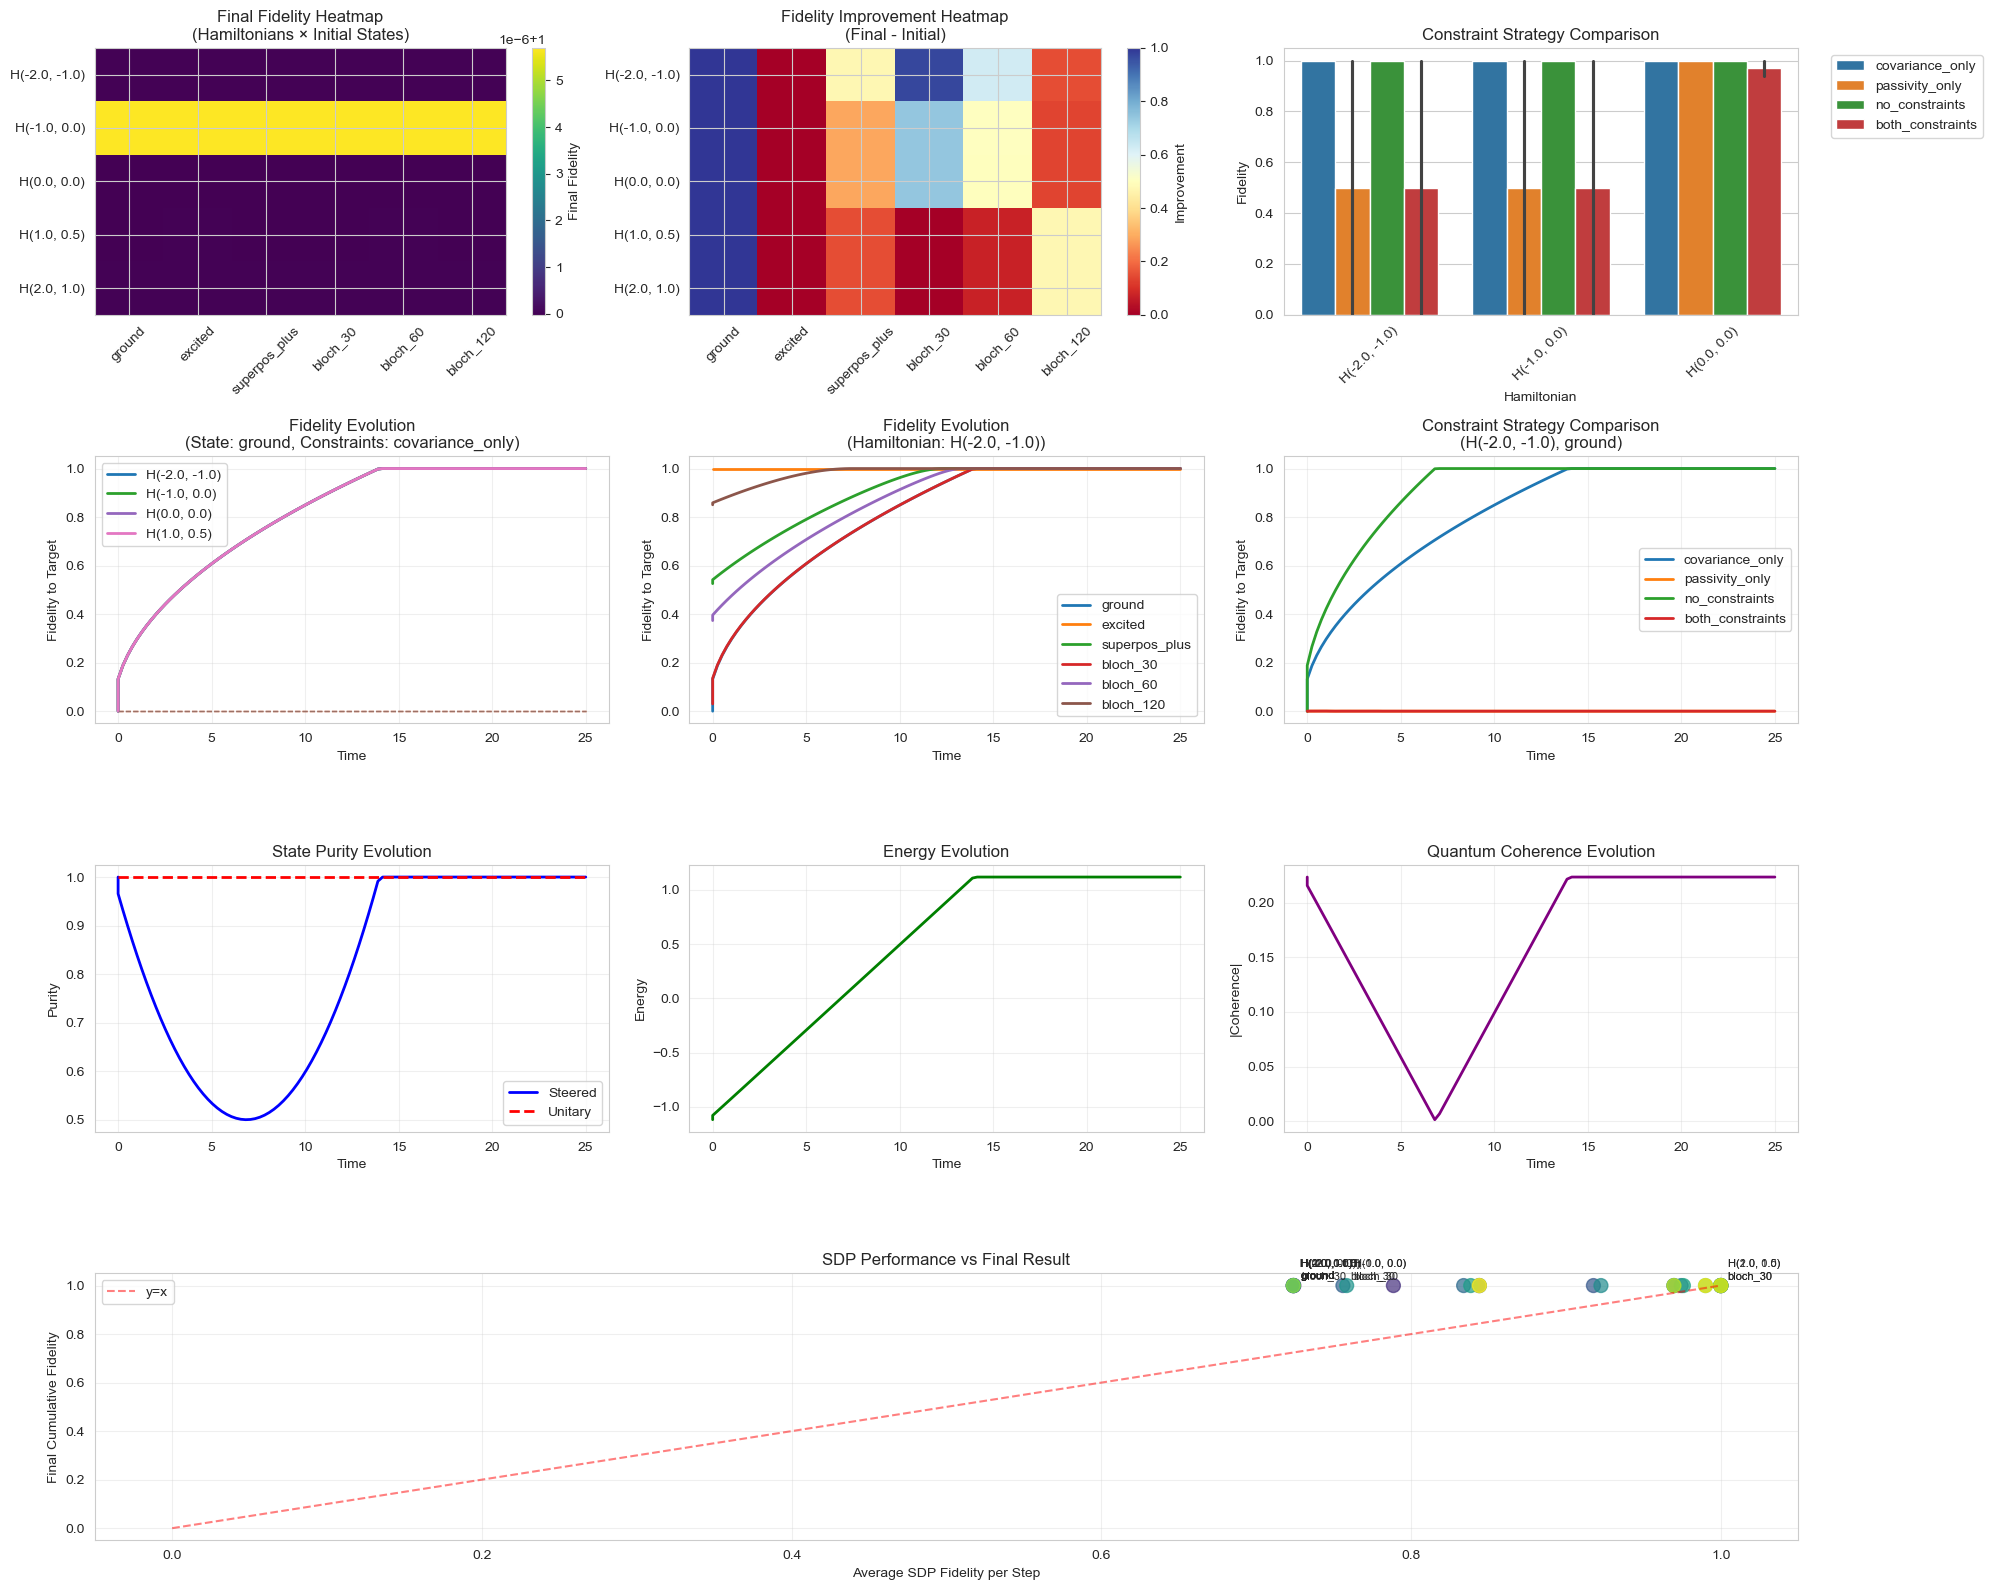

/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/matplotlib/collections.py:200: ComplexWarning: Casting complex values to real discards the imaginary part
  offsets = np.asanyarray(offsets, float)
/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/tchatterjee/anaconda3/envs/pmp/lib/python3.13/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_7090/3319084018.py:218: UserWarning: Glyph 10216 (\N{MATHEMATICAL LEFT ANGLE BRACKET}) missing from font(s) Arial.
  plt.tight_layout()
/var/folders/7d/xvfh5ghn7gd9q1vmfcky51h80000gn/T/ipykernel_7090/3319084018.py:218: UserWarning: Glyph 10217 (\N{MATHEMATICAL RIGHT ANGLE BRACKET}) missing from font(s) Arial.
  plt.tight_layout()


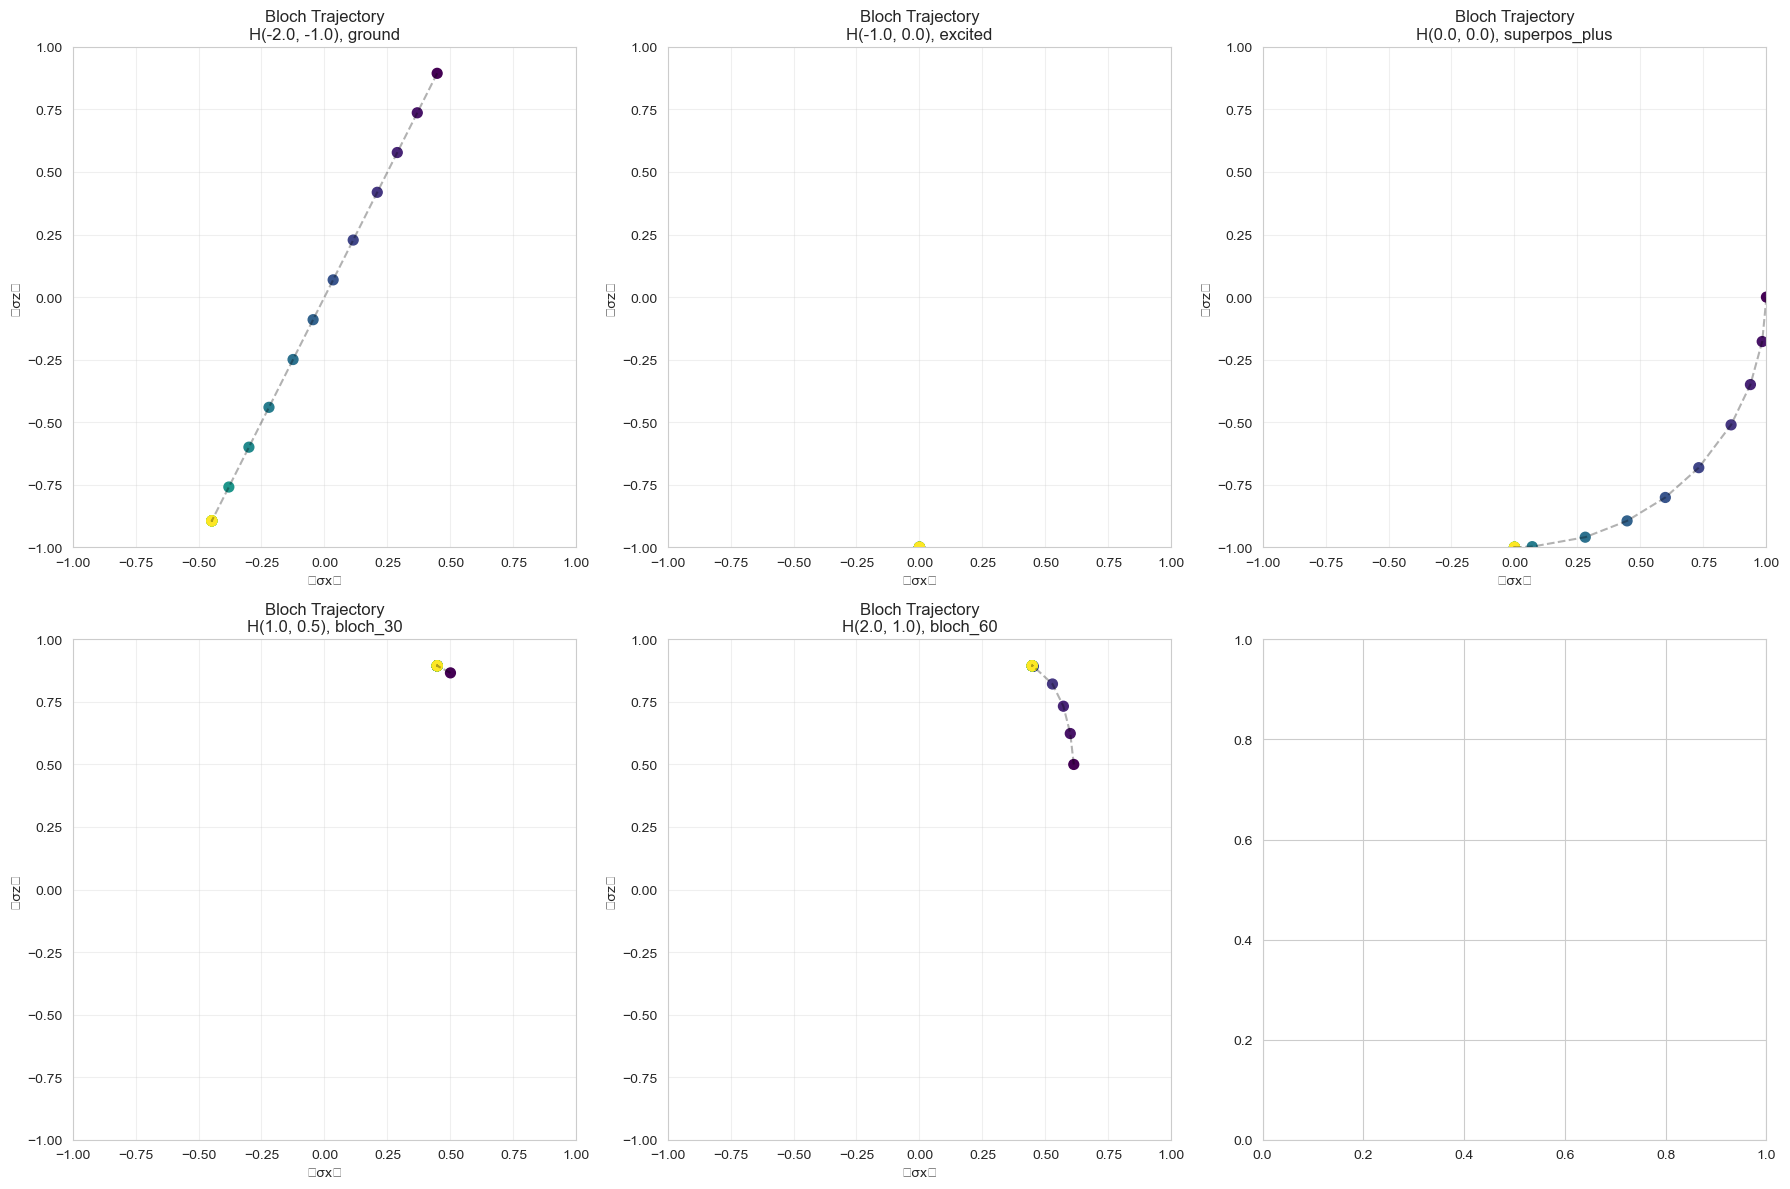

In [5]:
# %%
# ===============================================================
# RUN MEGA-ANALYSIS
# ===============================================================

# Extended parameter space
a_vals = np.linspace(-2, 2, 5)
b_vals = np.linspace(-1, 1, 5)
hams = generate_hamiltonians(a_vals, b_vals)

# Select diverse Hamiltonians for analysis
hamiltonian_keys = [(-2.0, -1.0), (-1.0, 0.0), (0.0, 0.0), (1.0, 0.5), (2.0, 1.0)]

# Define initial states
initial_states = {
    'ground': {'type': 'ground'},
    'excited': {'type': 'excited'},
    'superpos_plus': {'type': 'superposition'},
    'bloch_30': {'type': 'bloch', 'theta': np.pi/6, 'phi': 0},
    'bloch_60': {'type': 'bloch', 'theta': np.pi/3, 'phi': np.pi/4},
    'bloch_120': {'type': 'bloch', 'theta': 2*np.pi/3, 'phi': np.pi/2}
}

# Constraint configurations
constraint_configs = {
    'covariance_only': {
        'impose_covariance': True,
        'impose_passivity': False,
        'eta': 0.1
    },
    'passivity_only': {
        'impose_covariance': False,
        'impose_passivity': True,
        'eta': 0.1
    },
    'no_constraints': {
        'impose_covariance': False,
        'impose_passivity': False,
        'eta': 0.2
    },
    'both_constraints': {
        'impose_covariance': True,
        'impose_passivity': True,
        'eta': 0.05
    }
}

# Time evolution parameters
tlist = np.linspace(0, 25, 100)

# Analysis parameters
analysis_params = {
    'initial_states': initial_states,
    'constraint_configs': constraint_configs
}

print("Starting comprehensive analysis...")
print(f"Hamiltonians: {len(hamiltonian_keys)}")
print(f"Initial states: {len(initial_states)}")
print(f"Constraint configs: {len(constraint_configs)}")
print(f"Total runs: {len(hamiltonian_keys) * len(initial_states) * len(constraint_configs)}")

# Run the comprehensive analysis
all_results = comprehensive_steering_analysis(
    {k: hams[k] for k in hamiltonian_keys},  # Only selected Hamiltonians
    tlist, 
    analysis_params
)

# Create visualizations
fig1, fig2 = create_comprehensive_visualizations(
    all_results, tlist, hamiltonian_keys, initial_states, constraint_configs
)


In [6]:
# %%
# ===============================================================
# SUMMARY STATISTICS
# ===============================================================

print("\n" + "="*80)
print("COMPREHENSIVE ANALYSIS SUMMARY")
print("="*80)

# Collect summary statistics
summary_data = []
for h_key in hamiltonian_keys:
    for state_name in initial_states.keys():
        for constraint_name in constraint_configs.keys():
            result = all_results[h_key][state_name][constraint_name]
            summary_data.append({
                'Hamiltonian': f"H{h_key}",
                'Initial_State': state_name,
                'Constraints': constraint_name,
                'Initial_Fidelity': result['metrics']['fidelities'][0],
                'Final_Fidelity': result['final_fidelity'],
                'Improvement': result['improvement'],
                'Avg_SDP_Fidelity': np.nanmean(result['metrics']['sdp_fidelities'])
            })

df_summary = pd.DataFrame(summary_data)

# Print key insights
print("\nTOP 5 PERFORMING CONFIGURATIONS:")
top_configs = df_summary.nlargest(5, 'Final_Fidelity')[['Hamiltonian', 'Initial_State', 'Constraints', 'Final_Fidelity', 'Improvement']]
print(top_configs.to_string(index=False))

print("\nCONSTRAINT STRATEGY PERFORMANCE:")
constraint_stats = df_summary.groupby('Constraints').agg({
    'Final_Fidelity': ['mean', 'max', 'min'],
    'Improvement': ['mean', 'max']
}).round(4)
print(constraint_stats)

print("\nINITIAL STATE PERFORMANCE:")
state_stats = df_summary.groupby('Initial_State').agg({
    'Final_Fidelity': ['mean', 'max'],
    'Improvement': ['mean', 'max']
}).round(4)
print(state_stats)

print("\nHAMILTONIAN PERFORMANCE:")
hamiltonian_stats = df_summary.groupby('Hamiltonian').agg({
    'Final_Fidelity': ['mean', 'max'],
    'Improvement': ['mean', 'max']
}).round(4)
print(hamiltonian_stats)

# Best overall configuration
best_overall = df_summary.loc[df_summary['Final_Fidelity'].idxmax()]
print(f"\n🏆 BEST OVERALL CONFIGURATION:")
print(f"  Hamiltonian: {best_overall['Hamiltonian']}")
print(f"  Initial State: {best_overall['Initial_State']}")
print(f"  Constraints: {best_overall['Constraints']}")
print(f"  Final Fidelity: {best_overall['Final_Fidelity']:.4f}")
print(f"  Improvement: {best_overall['Improvement']:.4f}")

print(f"\n📊 ANALYSIS COMPLETE!")
print(f"Total configurations analyzed: {len(df_summary)}")
print(f"Average final fidelity: {df_summary['Final_Fidelity'].mean():.4f}")
print(f"Maximum fidelity achieved: {df_summary['Final_Fidelity'].max():.4f}")


COMPREHENSIVE ANALYSIS SUMMARY

TOP 5 PERFORMING CONFIGURATIONS:
 Hamiltonian Initial_State     Constraints  Final_Fidelity  Improvement
H(-1.0, 0.0)       excited covariance_only        1.000006     0.000006
H(-1.0, 0.0) superpos_plus covariance_only        1.000006     0.292899
H(-1.0, 0.0)        ground covariance_only        1.000006     1.000006
H(-1.0, 0.0)      bloch_30 covariance_only        1.000006     0.741187
H(-1.0, 0.0)      bloch_60 covariance_only        1.000006     0.500006

CONSTRAINT STRATEGY PERFORMANCE:
                 Final_Fidelity           Improvement        
                           mean  max  min        mean     max
Constraints                                                  
both_constraints         0.6863  1.0  0.0      0.0846  0.9407
covariance_only          1.0000  1.0  1.0      0.3983  1.0000
no_constraints           1.0000  1.0  1.0      0.3983  1.0000
passivity_only           0.7211  1.0  0.0      0.1194  1.0000

INITIAL STATE PERFORMANCE:
      